In [1]:
import sys
import os

current_dir=os.getcwd()
parent_dir=os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import pandas as pd
import numpy as np
from utils.logger import LoggerHelper

In [2]:
dataset_path = 'adhdata.csv'
logger=LoggerHelper.get_logger()

In [3]:
try:
    df = pd.read_csv(dataset_path)
    logger.info("Data is successfully loaded. The first 5 rows\n:", df.head())
    print(df.head())
    logger.info("df info:\n", df.info())
    

except FileNotFoundError:
    logger.error(f"File not found: {dataset_path}")
except Exception as e:
    logger.error(f"File loading failed with error: {e}")
    
    

     Fp1    Fp2     F3     F4     C3     C4     P3     P4     O1     O2  ...  \
0  261.0  402.0   16.0  261.0  126.0  384.0  126.0  236.0   52.0  236.0  ...   
1  121.0  191.0  -94.0   85.0   16.0  200.0  126.0   52.0  347.0  273.0  ...   
2  -55.0   85.0 -204.0   15.0  -57.0  200.0   52.0  126.0  236.0  200.0  ...   
3  191.0   85.0   52.0   50.0   89.0  236.0  163.0   89.0   89.0   89.0  ...   
4  -55.0 -125.0 -204.0 -160.0 -204.0   16.0 -241.0 -241.0   89.0   16.0  ...   

      F8     T7     T8     P7     P8     Fz     Cz     Pz  Class    ID  
0   16.0  200.0  494.0  126.0  236.0  121.0  367.0  121.0   ADHD  v10p  
1  -57.0  126.0  347.0   52.0   52.0   15.0  121.0  -19.0   ADHD  v10p  
2  -94.0  126.0  420.0   52.0  126.0  -55.0  261.0   85.0   ADHD  v10p  
3  -57.0  236.0  420.0  126.0  126.0   15.0   85.0  -55.0   ADHD  v10p  
4 -131.0   89.0  310.0  -57.0   52.0  -55.0   15.0 -336.0   ADHD  v10p  

[5 rows x 21 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166383 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\pelin\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pelin\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\pelin\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pelin\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\pelin\AppData\Local\Programs\Python\Python312\Lib\runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users

In [4]:
df['Class'].value_counts()

Class
ADHD       1207069
Control     959314
Name: count, dtype: int64

In [5]:
df['ID'].value_counts() # denek görevi bitene kadar kayıt alınır. Demek ki bu deneğin görevi tamamlaması daha uzun sürmüş olabilir.
# ya da ham eeg sinyalleri gürültülü olduğu için de olabilir. Göz kırpma, kas gerginliği, öksürme vs. beyin sinyalini bozabilir.
# modelimize bu şekilde bir veri veremeyiz. Veri düzensiz bir yapıda şu an.
# Tüm deneklerden en kısa olanı baz alıp diğerlerinin sonrasını kesip atayım deme.
# örneğin bir deneğin değerli verisini çöpe atmış oluruz. Modelin öğrenme kapasitesi düşer.
# windowing veya epoching yapıcam:
# Sürekli bir sinyali sınıflandırmak yerine o sinyali ADHD veya Control belirtisi gösteren küçük, 
# sabit boyutlu "anlara" (pencerelere) böleriz.
# 1) Tüm deneklerin uzun sinyallerini alırız.
# 2) Sabit boyutlu bir pencere boyutu seçeriz. Örneğin 2 sn lik anlar. Örnekleme frekansı 128Hz ile 
# 128*2=156 satır eder.
# Böylelikle örneğin v15p (43252 satır) 43252/256 yaklaşık 168 adet eğitime uygun sample üretir.
# Hem düzenli bir veri seti elde ederiz hem de (19 kanal * 256 zaman noktası) içeren yeni bir veri seti elde ederiz.
# CNN veya LTSM için perfect.
# Ama data leakage olabilir çünkü model train test split yaparken ayrırdığımız farklı sampleların aslında
# aynı kişinin beynine ait olduğunu fark edip veriyi ezberleyebilir.
# Bu yüzden GroupKFold kullanmak gerekir. GroupKFold'a bu pencerelerin hangi orijinal ID'de geldiğini
# söylemeliyiz.
# Böylece v15p den gelen pencerelerin tamamı ya eğitim veri setine ya da test setine gider.

ID
v15p    43252
v244    39030
v20p    35328
v234    34191
v3p     33570
        ...  
v25p     9894
v238     9852
v46p     9823
v37p     9286
v51p     7983
Name: count, Length: 121, dtype: int64

In [6]:
# adhd olan hastalar 1, control grubu 0 olarak belirledik.
class_mapping = {
    'ADHD': 1,
    'Control': 0
    
}

In [7]:
y_encoded = df['Class'].map(class_mapping)
print(f"\n'Class' column is successfully encoded to be either 1 or 0.")


'Class' column is successfully encoded to be either 1 or 0.


In [8]:
# X ve group (id) olarak ayırcaz.
# bu bize pandas serisi dönecek, sadece idleri içerecek.
# bu bizim meta verimiz, verimizi tanımlayan veri. 
# modelimizin bunu öğrenmesi gerekmez.
# id bilgisini hangi pencerenin nereden geldiğini takip etmek (bunu yaptık pencerelerken)
# ve cross validation yaparken kullanacağız.
groups = df['ID']

In [9]:
X_features = df.drop(columns=['ID', 'Class'], axis=1)
print(f"Data is successfuly divided as X, y and groups.")

Data is successfuly divided as X, y and groups.


In [10]:
print(f"X_features shape: {X_features.shape}")
print(f"y_encoded shape: {y_encoded.shape}")
print(f"groups shape: {groups.shape}")

X_features shape: (2166383, 19)
y_encoded shape: (2166383,)
groups shape: (2166383,)


In [11]:
# Saniyede 128 örnek
SAMPLING_RATE = 128 # Hz
WINDOW_SECONDS = 2 # Her bir pencerede 2snlik veri içersin.
# 128 * 2 = 256
WINDOW_SIZE = SAMPLING_RATE * WINDOW_SECONDS
# İki pencere arasında ne kadar kayma overlap olacağı.
STEP_SECONDS = 0.5 # 
# Eğer STEP_SIZE < WINDOW_SIZE olursa, pencereler örtüşür.
STEP_SIZE = int(SAMPLING_RATE * STEP_SECONDS) # 128 * 0.5 = 64

In [12]:
print(f"Starting sliding the windows...")
print(f"Window size: {WINDOW_SIZE} samples ({WINDOW_SECONDS} sec)")
print(f"Step size {STEP_SIZE} sample ({STEP_SECONDS} sec)")

Starting sliding the windows...
Window size: 256 samples (2 sec)
Step size 64 sample (0.5 sec)


In [13]:
unique_groups = groups.unique()

In [14]:
print(f"Total of {len(unique_groups)} unique groups. Processing...")

Total of 121 unique groups. Processing...


In [15]:
X_windows = []
y_windows = []
group_windows = []
for group_id in unique_groups:
    # groups == group_id boolean maske oluşturur.
    # X_features[...] bu maskeyi kullanarak SADECE o deneğe ait (40.000) satırı çeker.
    # O deneğe ait (40000, 19) 
    subject_X = X_features[groups == group_id]
    subject_y_series = y_encoded[groups == group_id]
    subject_y_series = subject_y_series.iloc[0]
    for i in range(0, len(subject_X) - WINDOW_SIZE + 1, STEP_SIZE):
        window_X_slice = subject_X.iloc[i : i + WINDOW_SIZE] # 256 satırlık kesiti al.
        # X_windows içerisine (i, 256) arasındaki değerleri numpy array'e dönüştür ve ekle. (256, 19) boyutlu bir array olur.
        X_windows.append(window_X_slice.values)
        y_windows.append(subject_y_series)
        group_windows.append(group_id)
        
    print("\nConverting is completing. Numpy arrays are created...")   
    X_final = np.array(X_windows)
    y_final = np.array(y_windows)
    groups_final = np.array(group_windows)


Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Converting is completing. Numpy arrays are created...

Convertin

In [16]:
print("\n--- PENCERELEME TAMAMLANDI ---")
print(f"Yeni X (X_final) Boyutu (Shape): {X_final.shape}")
print(f"Yeni y (y_final) Boyutu (Shape): {y_final.shape}")
print(f"Yeni groups (groups_final) Boyutu (Shape): {groups_final.shape}")


--- PENCERELEME TAMAMLANDI ---
Yeni X (X_final) Boyutu (Shape): (33434, 256, 19)
Yeni y (y_final) Boyutu (Shape): (33434,)
Yeni groups (groups_final) Boyutu (Shape): (33434,)


In [17]:
X_final

array([[[ 261.,  402.,   16., ...,  121.,  367.,  121.],
        [ 121.,  191.,  -94., ...,   15.,  121.,  -19.],
        [ -55.,   85., -204., ...,  -55.,  261.,   85.],
        ...,
        [ 261.,  226.,  126., ...,  121.,  -55.,   50.],
        [ -55.,   15., -131., ...,  -55.,   85.,   85.],
        [ 121.,  156.,  163., ...,  -19.,  191.,  226.]],

       [[1493., 1458.,  236., ...,  226.,  261.,  -19.],
        [1669., 1740.,  273., ...,  332.,  543.,  226.],
        [1986., 1881.,  604., ...,  437.,  543.,  297.],
        ...,
        [ 367.,  332.,  273., ...,  191.,   15.,  -55.],
        [ 156.,  261.,  163., ...,  191.,  156.,  -19.],
        [ 367.,  402.,  531., ...,  332.,  191.,   85.]],

       [[ 297.,   15.,  310., ...,  332.,  -55.,  297.],
        [ 261.,  121.,  273., ...,  332.,  156.,  437.],
        [ 473.,  261.,  457., ...,  297.,   15.,  367.],
        ...,
        [-618., -653.,  163., ...,   15.,   15.,  332.],
        [-864., -723.,   16., ...,  -55.,  12

Biz, her bir penceredeki (33434) her bir kanalın (19) 256 zaman adımı boyunca ortalamasını almak istiyoruz. Yani axis=1'i "çökertmek" (collapse) istiyoruz. Bu boyuttaki elemanların hepsini seç demiş oluyoruz. 
* 0 33434 pencere içindeen sadece ilk pencereyi seç.
* : O pencerenin içindeki tüm 256 zaman adımını seç.
* Zaman adımlarından da sadece ilk kanalı (index 0) seç. Bu tek bir sinyal parçası olur.

In [18]:
X_collapse = X_final[0, :, 0]

In [19]:
X_collapse

array([ 261.,  121.,  -55.,  191.,  -55.,  -19.,  -90., -336., 1388.,
       1177., 1212., 1212.,  930., 1106.,  860.,  789.,  860.,  508.,
        649.,  508.,  402.,  578.,  226.,  367.,  156.,  402.,  226.,
        367.,  367.,  121.,  402.,  261.,  297.,  402.,  261.,  543.,
        437.,  367.,  473.,  156.,  332.,  297.,  261.,  473.,  191.,
        297.,  261.,  121.,  367.,  191.,  332.,  437.,  261.,  508.,
        367.,  402.,  543.,  297.,  543.,  437.,  473.,  860.,  789.,
       1212., 1493., 1669., 1986., 1740., 1845., 1881., 1599., 1599.,
       1141.,  930.,  719.,  297.,  473.,  156.,  -19.,  -90., -547.,
       -512., -653., -723., -618., -970., -899., -935., -970., -688.,
       -935., -794., -653., -723., -477., -759., -688., -512., -583.,
       -266., -371., -371., -231., -442.,  -90., -160., -301., -125.,
       -336.,  -55.,   15.,  -90.,   85., -125.,   85.,  191.,  -55.,
        121.,  -55.,   15.,  191.,   85.,  261.,   85.,  191.,  437.,
        226.,  402.,

In [20]:
X_collapse.shape # tek boyutlu 256lık np arraye döndürdük

(256,)

Bu ikisini 19 mean 19 std olacak şekilde birleştirip bir matris elde ediyoruz. np.concatenate() kullanıcaz. Hangi axisten birleştirmemiz gerektiğini parametre olarak vermemiz gerekir. Modele vereceğimiz veri matris olmalı. 33k tane veriyi modele verip her bir veri için 2 snlik yani 128*2=256 zaman adımlı eeg sinyali var.256 sayının tamamını okumak yerine sinyali özetleyen bilgiler veririz. mean o penceredeki voltajın ortalamasını alır. o penceredeki sinyalin genel seviyesini bulur. Yeni elde edeceğimiz shape'in ikinci elemanı yani 19 bizim çıkaracağımız öznitelik sayısıdır. Bunun için 33434 pencerenin her birini ve her penceredeki 19 kanalı tek tek işlememiz gerekiyor.

Time Domain: Sinyalin kendi değerleri üzerinden hesaplanan basit istatistikler.
Frequency Domain: Sinyalin Teta, Beta gibi beyin dalgalarını içeren güç bilgileri (fft veya Welch metodu ile) 

In [21]:
mean_features = X_final.mean(axis=1)
std_features = X_final.std(axis=1)

concatenate fonksiyonu birleştirilecek arrayleri tuple olarak alır. 
axis=1 sütunları yan yana ekler. böylece (33434, 38) olur shape.

In [22]:
features_time_domain = np.concatenate((mean_features, std_features), axis=1)

In [23]:
features_time_domain.shape

(33434, 38)

In [24]:
mean_features.shape 


(33434, 19)

In [25]:
std_features.shape

(33434, 19)

In [26]:
mean_features

array([[214.41015625, 227.1875    , 149.32421875, ..., 154.6015625 ,
        138.6875    , 119.015625  ],
       [150.609375  , 144.828125  , 144.05859375, ..., 139.8203125 ,
        136.671875  , 151.9140625 ],
       [196.625     , 187.80078125, 176.23046875, ..., 169.921875  ,
        133.48828125, 180.90234375],
       ...,
       [112.8046875 , 121.3125    , 119.02734375, ..., 111.21875   ,
        118.25390625, 119.26171875],
       [111.2890625 , 120.4765625 , 120.0234375 , ..., 117.78125   ,
        113.984375  , 105.953125  ],
       [128.58984375, 129.6796875 , 134.3671875 , ..., 128.62890625,
        132.3828125 , 130.265625  ]], shape=(33434, 19))

In [27]:

save_path="X_final.npy"
np.save(save_path, X_final)
logger.info(f"File saved: {os.path.abspath(save_path)}")

2025-12-17 16:31:05 - INFO - eeg_pipeline - File saved: c:\Users\pelin\JupyterNotebookProjects\ADHD\pediatric\X_final.npy


In [30]:
from scipy.signal import iirnotch, butter, filtfilt, welch
import matplotlib.pyplot as plt
import numpy as np


def apply_eeg_filters(df, channels, fs=128):
    
    b_notch, a_notch = iirnotch(50.0, 30.0, fs)
    
    b_band, a_band = butter(2, [1.0, 60.0], btype='band', fs=fs)
    
    df_filtered = df.copy()
    for col in channels:
        sig = df[col].values
        sig = filtfilt(b_notch, a_notch, sig)
        sig = filtfilt(b_band, a_band, sig)
        df_filtered[col] = sig
    return df_filtered


def plot_all_channels_psd(X_data, y_labels, fs=128):
    plt.figure(figsize=(10, 6))
    configs = [{'val': 1, 'label': 'ADHD', 'color': 'blue'},
               {'val': 0, 'label': 'Control', 'color': 'hotpink'}]
    
    for config in configs:
        mask = (y_labels == config['val'])
        class_data = X_data[mask] # (Denek, Zaman, Kanal)
        
        
        all_psds = []
        for ch in range(class_data.shape[2]):
            freqs, psds = welch(class_data[:, :, ch], fs=fs, nperseg=256, axis=1)
            all_psds.append(np.mean(psds, axis=0))
            
        avg_psd_across_channels = np.mean(all_psds, axis=0)
        plt.semilogy(freqs, avg_psd_across_channels, label=config['label'], color=config['color'], lw=2)

    plt.title("Mean Power Spectral Density (All 19 Channels)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (dB/Hz)")
    plt.axvspan(4, 8, color='blue', alpha=0.1, label='Theta Band')
    plt.axvspan(13, 30, color='hotpink', alpha=0.1, label='Beta Band')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()


eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']
X_features_filtered = apply_eeg_filters(X_features, eeg_channels, fs=128)


plot_all_channels_psd(X_final_filtered, y_final, fs=128)

NameError: name 'X_final_filtered' is not defined

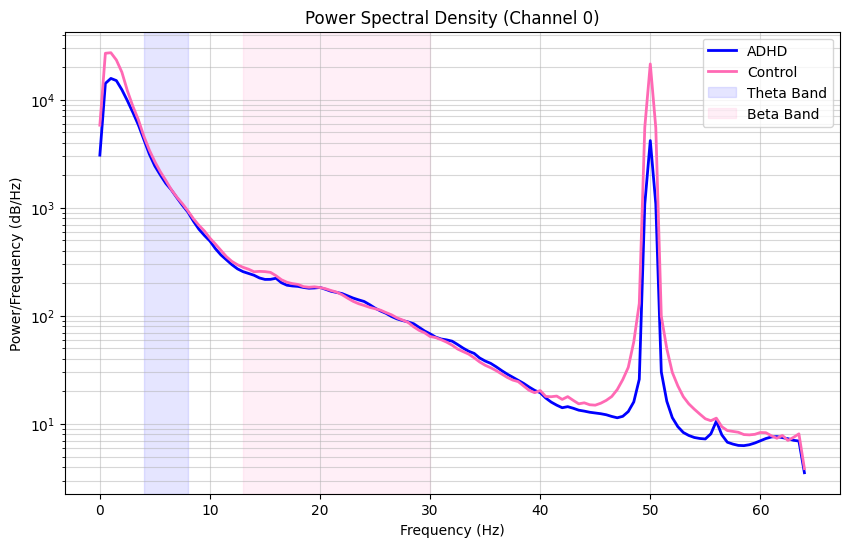

In [29]:
from scipy.signal import welch
import matplotlib.pyplot as plt

def plot_psd_comparison(X_data, y_labels, channel_idx=0, fs=128):
    plt.figure(figsize=(10, 6))
    
    configs = [
        {'val': 1, 'label': 'ADHD', 'color': 'blue'},
        {'val': 0, 'label': 'Control', 'color': 'hotpink'}
    ]
    
    for config in configs:
        mask = (y_labels == config['val'])
        
        # Notebook'undaki X_final (X_data) yapısına göre: (pencere, zaman, kanal)
        # Sadece ilgili sınıfa ait ve seçilen kanaldaki veriyi alıp düzleştiriyoruz
        class_signals = X_data[mask, :, channel_idx].reshape(-1)
        
        freqs, psd = welch(class_signals, fs=fs, nperseg=256)
        
        plt.semilogy(freqs, psd, 
                     label=config['label'], 
                     color=config['color'], 
                     linewidth=2)

    plt.title(f"Power Spectral Density (Channel {channel_idx})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (dB/Hz)")
    
    plt.axvspan(4, 8, color='blue', alpha=0.1, label='Theta Band')
    plt.axvspan(13, 30, color='hotpink', alpha=0.1, label='Beta Band')
    
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

# Kendi verilerinle (X_final ve y_final) metodu çağırıyoruz:
plot_psd_comparison(X_final, y_final, channel_idx=0, fs=SAMPLING_RATE)

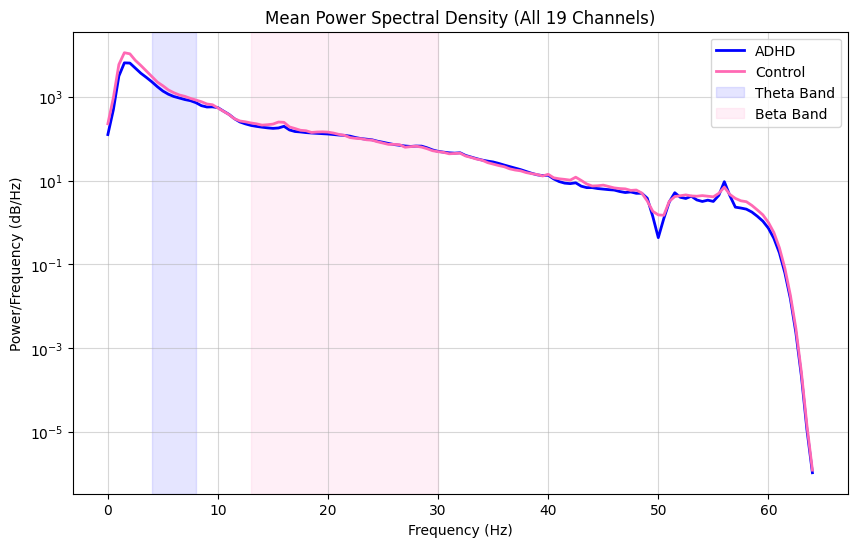

In [31]:
from scipy.signal import iirnotch, butter, filtfilt, welch
import matplotlib.pyplot as plt
import numpy as np

def apply_eeg_filters(df, channels, fs=128):
    
    b_notch, a_notch = iirnotch(50.0, 30.0, fs)
    
    b_band, a_band = butter(2, [1.0, 60.0], btype='band', fs=fs)
    
    df_filtered = df.copy()
    for col in channels:
        sig = df[col].values
        sig = filtfilt(b_notch, a_notch, sig)
        sig = filtfilt(b_band, a_band, sig)
        df_filtered[col] = sig
    return df_filtered


def plot_all_channels_psd(X_data, y_labels, fs=128):
    plt.figure(figsize=(10, 6))
    configs = [{'val': 1, 'label': 'ADHD', 'color': 'blue'},
               {'val': 0, 'label': 'Control', 'color': 'hotpink'}]
    
    for config in configs:
        mask = (y_labels == config['val'])
        class_data = X_data[mask] 
        
        all_psds = []
        for ch in range(class_data.shape[2]):
            freqs, psds = welch(class_data[:, :, ch], fs=fs, nperseg=256, axis=1)
            all_psds.append(np.mean(psds, axis=0))
            
        avg_psd_across_channels = np.mean(all_psds, axis=0)
        plt.semilogy(freqs, avg_psd_across_channels, label=config['label'], color=config['color'], lw=2)

    plt.title("Mean Power Spectral Density (All 19 Channels)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (dB/Hz)")
    plt.axvspan(4, 8, color='blue', alpha=0.1, label='Theta Band')
    plt.axvspan(13, 30, color='hotpink', alpha=0.1, label='Beta Band')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()



eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']
X_features_filtered = apply_eeg_filters(X_features, eeg_channels, fs=128)

X_windows_filtered = []

for group_id in unique_groups:
    subject_X = X_features_filtered[groups == group_id]
    for i in range(0, len(subject_X) - WINDOW_SIZE + 1, STEP_SIZE):
        window_X_slice = subject_X.iloc[i : i + WINDOW_SIZE]
        X_windows_filtered.append(window_X_slice.values)

X_final_filtered = np.array(X_windows_filtered)


plot_all_channels_psd(X_final_filtered, y_final, fs=128)